In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import multi_gpu_model

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO(conv_num=1):
    init_channel = 256
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel/(2**int((i+1)/4))), 
                          strides=1, padding='same', activation='relu'))
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 256)        1536      
_________________________________________________________________
flatten (Flatten)            (None, 4096000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 4096000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                65536016  
Total params: 65,537,552
Trainable params: 65,537,552
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (ty

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 5333, 256)         0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 5333, 256)         327936    
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 1777, 256)         0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 1777, 256)         327936    
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 592, 256)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0393 - acc: 0.3297
Epoch 00001: val_loss improved from inf to 1.42635, saving model to model/checkpoint/1D_CNN_custom_2_DO_6_conv_checkpoint/001-1.4264.hdf5
36805/36805 [==============================] - 181s 5ms/sample - loss: 2.0392 - acc: 0.3297 - val_loss: 1.4264 - val_acc: 0.5539
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3612 - acc: 0.5603
Epoch 00002: val_loss improved from 1.42635 to 1.12642, saving model to model/checkpoint/1D_CNN_custom_2_DO_6_conv_checkpoint/002-1.1264.hdf5
36805/36805 [==============================] - 179s 5ms/sample - loss: 1.3610 - acc: 0.5603 - val_loss: 1.1264 - val_acc: 0.6497
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0875 - acc: 0.6579
Epoch 00003: val_loss improved from 1.12642 to 0.93626, saving model to model

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1524 - acc: 0.9511
Epoch 00025: val_loss did not improve from 0.31751
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.1524 - acc: 0.9511 - val_loss: 0.3201 - val_acc: 0.9201
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1442 - acc: 0.9529
Epoch 00026: val_loss did not improve from 0.31751
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.1442 - acc: 0.9529 - val_loss: 0.3439 - val_acc: 0.9196
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1381 - acc: 0.9558
Epoch 00027: val_loss did not improve from 0.31751
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.1382 - acc: 0.9558 - val_loss: 0.3368 - val_acc: 0.9196
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1302 - acc: 0.9583
Epoch 00028: val_loss did not improve from 0.31751
36805/36805 [========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0564 - acc: 0.9820
Epoch 00055: val_loss did not improve from 0.31751
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.0564 - acc: 0.9820 - val_loss: 0.4303 - val_acc: 0.9264
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0540 - acc: 0.9822
Epoch 00056: val_loss did not improve from 0.31751
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.0540 - acc: 0.9822 - val_loss: 0.3965 - val_acc: 0.9315
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0566 - acc: 0.9820
Epoch 00057: val_loss did not improve from 0.31751
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.0566 - acc: 0.9820 - val_loss: 0.3898 - val_acc: 0.9262
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0515 - acc: 0.9832
Epoch 00058: val_loss did not improve from 0.31751
36805/36805 [========

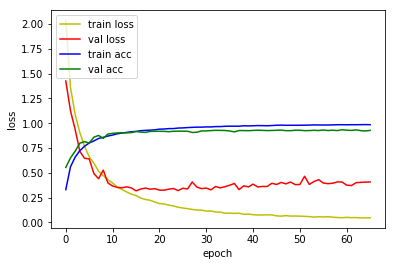

4815/4815 [==============================] - 21s 4ms/sample - loss: 0.3904 - acc: 0.8866
Loss: 0.39037198481901414 Accuracy: 0.88660437

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1621 - acc: 0.2878
Epoch 00001: val_loss improved from inf to 1.62771, saving model to model/checkpoint/1D_CNN_custom_2_DO_7_conv_checkpoint/001-1.6277.hdf5
36805/36805 [==============================] - 180s 5ms/sample - loss: 2.1620 - acc: 0.2878 - val_loss: 1.6277 - val_acc: 0.4505
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4567 - acc: 0.5158
Epoch 00002: val_loss improved from 1.62771 to 1.07026, saving model to model/checkpoint/1D_CNN_custom_2_DO_7_conv_checkpoint/002-1.0703.hdf5
36805/36805 [==============================] - 179s 5ms/sample - loss: 1.4566 - acc: 0.5159 - val_loss: 1.0703 - val_acc: 0.6862
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1065 - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1442 - acc: 0.9535
Epoch 00024: val_loss did not improve from 0.17595
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.1443 - acc: 0.9535 - val_loss: 0.1987 - val_acc: 0.9497
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1361 - acc: 0.9548
Epoch 00025: val_loss did not improve from 0.17595
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.1360 - acc: 0.9548 - val_loss: 0.1870 - val_acc: 0.9511
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1389 - acc: 0.9555
Epoch 00026: val_loss did not improve from 0.17595
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.1390 - acc: 0.9555 - val_loss: 0.1955 - val_acc: 0.9455
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1313 - acc: 0.9568
Epoch 00027: val_loss improved from 0.17595 to 0.17431, saving model to model/checkpo

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0606 - acc: 0.9790
Epoch 00053: val_loss did not improve from 0.16233
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.0606 - acc: 0.9790 - val_loss: 0.1658 - val_acc: 0.9581
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0529 - acc: 0.9810
Epoch 00054: val_loss did not improve from 0.16233
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.0529 - acc: 0.9810 - val_loss: 0.2450 - val_acc: 0.9543
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0530 - acc: 0.9825
Epoch 00055: val_loss did not improve from 0.16233
36805/36805 [==============================] - 178s 5ms/sample - loss: 0.0530 - acc: 0.9825 - val_loss: 0.1899 - val_acc: 0.9588
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0518 - acc: 0.9824
Epoch 00056: val_loss did not improve from 0.16233
36805/36805 [========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0360 - acc: 0.9878
Epoch 00083: val_loss did not improve from 0.16233
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.0360 - acc: 0.9878 - val_loss: 0.1949 - val_acc: 0.9632

1D_CNN_custom_2_DO_7_conv Model


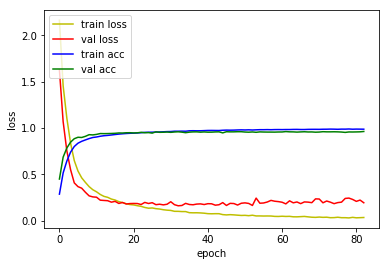

4815/4815 [==============================] - 21s 4ms/sample - loss: 0.1977 - acc: 0.9423
Loss: 0.1976632449423908 Accuracy: 0.9422638

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1577 - acc: 0.2901
Epoch 00001: val_loss improved from inf to 1.29534, saving model to model/checkpoint/1D_CNN_custom_2_DO_8_conv_checkpoint/001-1.2953.hdf5
36805/36805 [==============================] - 195s 5ms/sample - loss: 2.1577 - acc: 0.2901 - val_loss: 1.2953 - val_acc: 0.5970
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2236 - acc: 0.6009
Epoch 00002: val_loss improved from 1.29534 to 0.74195, saving model to model/checkpoint/1D_CNN_custom_2_DO_8_conv_checkpoint/002-0.7419.hdf5
36805/36805 [==============================] - 191s 5ms/sample - loss: 1.2234 - acc: 0.6010 - val_loss: 0.7419 - val_acc: 0.7780
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8681 - ac

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1107 - acc: 0.9646
Epoch 00026: val_loss did not improve from 0.12023
36805/36805 [==============================] - 194s 5ms/sample - loss: 0.1107 - acc: 0.9646 - val_loss: 0.1352 - val_acc: 0.9630
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1075 - acc: 0.9648
Epoch 00027: val_loss improved from 0.12023 to 0.11844, saving model to model/checkpoint/1D_CNN_custom_2_DO_8_conv_checkpoint/027-0.1184.hdf5
36805/36805 [==============================] - 175s 5ms/sample - loss: 0.1075 - acc: 0.9648 - val_loss: 0.1184 - val_acc: 0.9655
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1008 - acc: 0.9665
Epoch 00028: val_loss did not improve from 0.11844
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.1008 - acc: 0.9665 - val_loss: 0.1212 - val_acc: 0.9648
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

36800/36805 [============================>.] - ETA: 0s - loss: 0.0448 - acc: 0.9853
Epoch 00054: val_loss did not improve from 0.10413
36805/36805 [==============================] - 190s 5ms/sample - loss: 0.0448 - acc: 0.9853 - val_loss: 0.1618 - val_acc: 0.9616
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0406 - acc: 0.9866
Epoch 00055: val_loss did not improve from 0.10413
36805/36805 [==============================] - 175s 5ms/sample - loss: 0.0406 - acc: 0.9866 - val_loss: 0.1504 - val_acc: 0.9662
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0455 - acc: 0.9841
Epoch 00056: val_loss did not improve from 0.10413
36805/36805 [==============================] - 172s 5ms/sample - loss: 0.0455 - acc: 0.9841 - val_loss: 0.1430 - val_acc: 0.9669
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0420 - acc: 0.9860
Epoch 00057: val_loss did not improve from 0.10413
36805/36805 [=====================

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0257 - acc: 0.9917
Epoch 00084: val_loss did not improve from 0.10413
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.0257 - acc: 0.9917 - val_loss: 0.1673 - val_acc: 0.9646
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0218 - acc: 0.9929
Epoch 00085: val_loss did not improve from 0.10413
36805/36805 [==============================] - 190s 5ms/sample - loss: 0.0219 - acc: 0.9929 - val_loss: 0.1628 - val_acc: 0.9709
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0308 - acc: 0.9901
Epoch 00086: val_loss did not improve from 0.10413
36805/36805 [==============================] - 191s 5ms/sample - loss: 0.0308 - acc: 0.9901 - val_loss: 0.1473 - val_acc: 0.9695
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0265 - acc: 0.9916
Epoch 00087: val_loss did not improve from 0.10413
36805/36805 [========

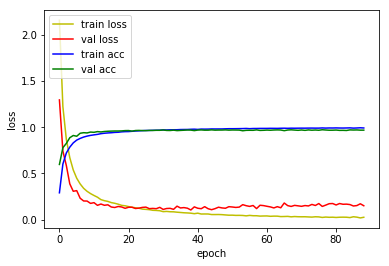

4815/4815 [==============================] - 21s 4ms/sample - loss: 0.1485 - acc: 0.9583
Loss: 0.14848895899541406 Accuracy: 0.95825547

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0928 - acc: 0.3263
Epoch 00001: val_loss improved from inf to 1.19802, saving model to model/checkpoint/1D_CNN_custom_2_DO_9_conv_checkpoint/001-1.1980.hdf5
36805/36805 [==============================] - 186s 5ms/sample - loss: 2.0928 - acc: 0.3263 - val_loss: 1.1980 - val_acc: 0.6508
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2744 - acc: 0.5905
Epoch 00002: val_loss improved from 1.19802 to 0.77553, saving model to model/checkpoint/1D_CNN_custom_2_DO_9_conv_checkpoint/002-0.7755.hdf5
36805/36805 [==============================] - 183s 5ms/sample - loss: 1.2744 - acc: 0.5905 - val_loss: 0.7755 - val_acc: 0.7713
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9745 - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1453 - acc: 0.9549
Epoch 00024: val_loss did not improve from 0.12967
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.1453 - acc: 0.9549 - val_loss: 0.1584 - val_acc: 0.9555
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1233 - acc: 0.9596
Epoch 00025: val_loss improved from 0.12967 to 0.12613, saving model to model/checkpoint/1D_CNN_custom_2_DO_9_conv_checkpoint/025-0.1261.hdf5
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.1233 - acc: 0.9595 - val_loss: 0.1261 - val_acc: 0.9639
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1202 - acc: 0.9615
Epoch 00026: val_loss did not improve from 0.12613
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.1202 - acc: 0.9615 - val_loss: 0.1426 - val_acc: 0.9609
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1133 - acc: 0

36800/36805 [============================>.] - ETA: 0s - loss: 0.0487 - acc: 0.9838
Epoch 00052: val_loss did not improve from 0.12264
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.0487 - acc: 0.9838 - val_loss: 0.1379 - val_acc: 0.9683
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0485 - acc: 0.9845
Epoch 00053: val_loss did not improve from 0.12264
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0485 - acc: 0.9844 - val_loss: 0.1728 - val_acc: 0.9665
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0495 - acc: 0.9832
Epoch 00054: val_loss did not improve from 0.12264
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0495 - acc: 0.9831 - val_loss: 0.1590 - val_acc: 0.9667
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0445 - acc: 0.9857
Epoch 00055: val_loss did not improve from 0.12264
36805/36805 [=====================

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.9911
Epoch 00082: val_loss did not improve from 0.12264
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0277 - acc: 0.9911 - val_loss: 0.1720 - val_acc: 0.9688
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0242 - acc: 0.9915
Epoch 00083: val_loss did not improve from 0.12264
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.0242 - acc: 0.9916 - val_loss: 0.1823 - val_acc: 0.9702
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0243 - acc: 0.9920
Epoch 00084: val_loss did not improve from 0.12264
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0243 - acc: 0.9920 - val_loss: 0.1836 - val_acc: 0.9686
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0285 - acc: 0.9912
Epoch 00085: val_loss did not improve from 0.12264
36805/36805 [========

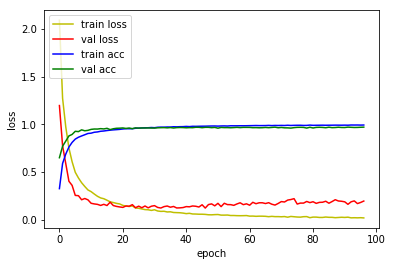

4815/4815 [==============================] - 19s 4ms/sample - loss: 0.1674 - acc: 0.9603
Loss: 0.16742254200421453 Accuracy: 0.9603323



In [10]:
for i in range(6, 10):
    base = '1D_CNN_custom_2_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO(conv_num=i)
        
    model = multi_gpu_model(model, gpus=2)
    
    #         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_2_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(6, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_2_DO_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_45_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_45_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_45_input[0][0]            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 16)           1364496     lambda[0][0]                     
                                                                 lambda_1[0]

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(6, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_2_DO_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_45_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_45_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_45_input[0][0]            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 16)           1364496     lambda[0][0]                     
                                                                 lambda_1[0]